In [1]:
import numpy as np
from sherpa.astro import xspec
from matplotlib import pyplot as plt



# define energy bin lower and upper bounds
e_lo = np.linspace(0.3, 10.99, 1070)
e_hi = np.linspace(0.31, 11.00, 1070)
e_bar = (e_lo + e_hi) / 2

m = xspec.XSvapec()
m.kT = 7.0
m.norm = 4.0

plt.plot(m(e_lo, e_hi))

from simulators import Simulator
from inputs import process_rmf

RMF = process_rmf(np.loadtxt('source_analysis/rmf.txt'))
ARF = np.loadtxt('source_analysis/arf.txt')
x0 = np.loadtxt('source_analysis/counts.txt')

T = 14479
delta_t = 3.2
delta_b = 0.01

class XspecModel:
    def __init__(self):
        self.model = xspec.XSvapec()

    def get_rate(self, params):
        self.model.kT = params[0]
        self.model.norm = params[1]
        return self.model(e_lo, e_hi) * delta_t * delta_b * ARF

def simulate_simple(params):
    model = XspecModel()
    simulator =  Simulator(
        spectrum=model, 
        time_steps=T, 
        pileup='channels', 
        in_RMF=RMF, 
        in_ARF=ARF, 
        in_ENERGY_BINS=e_bar,
        alpha=0.5)
    data = simulator(params)
    return np.bincount(data, minlength=1025)[1:]

plt.plot(simulate_simple((2.2,3)))
plt.plot(x0)

# this is the instead of SBI stuff to see if it works
from tqdm import tqdm

def sample_prior():
    return np.array([np.random.uniform(0.1, 50), np.random.uniform(0.1, 50)])

num_sims = 10000

xs = np.zeros((num_sims, 1024))
thetas = np.zeros((num_sims, 2))

for idx in tqdm(range(num_sims)):
    thetas[idx] = sample_prior()
    xs[idx] = simulate_simple(thetas[idx])

np.save('xspec_outputs/theta_vapec.npy', thetas)
np.save('xspec_outputs/x_vapec.npy', xs)

# change kernal


In [1]:
# conda deactivate
import torch
import numpy as np

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding
from sbi.inference import SNPE
from sbi.utils import posterior_nn

theta = torch.Tensor(np.load('xspec_outputs/theta_vapec.npy'))
x = torch.Tensor(np.load('xspec_outputs/x_vapec.npy'))
x0 = torch.Tensor(np.loadtxt('source_analysis/counts.txt'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-19 18:55:25.097207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sbi_tools import BoxUniform
from sbi.inference import prepare_for_sbi, simulate_for_sbi

prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([50, 50]))
#embedding_net = FCEmbedding(input_dim=1024, output_dim=100, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="maf", 
    #embedding_net=embedding_net, 
    hidden_features=1024, 
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)


_ = inference.append_simulations(theta, x, proposal=prior).train()
posterior = inference.build_posterior().set_default_x(x0)


 Neural network successfully converged after 38 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples: 102025it [02:12, 771.14it/s]                           


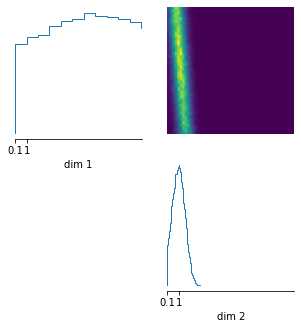

In [4]:
samples = posterior.sample((100000,), x=x0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 10], [0.1, 10]],
    ticks=[[0.1, 1,2,3,4,5,6,7,8,9,10], [0.1, 1,2,3,4,5,6,7,8,9,10]],
    figsize=(5, 5),
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [5]:
posterior = torch.load('xspec_outputs/posterior_vapec.pt')
proposals = posterior.sample((10000,), x=x0)
np.save('xspec_outputs/proposals_vapec.npy', proposals)

Drawing 10000 posterior samples: 11358it [00:12, 942.42it/s]


# CHANGE BACK KERNEL TO CIAO

In [2]:
import numpy as np
from sherpa.astro import xspec
from matplotlib import pyplot as plt

proposals = np.load('xspec_outputs/proposals_vapec.npy')

# define energy bin lower and upper bounds
e_lo = np.linspace(0.3, 10.99, 1070)
e_hi = np.linspace(0.31, 11.00, 1070)
e_bar = (e_lo + e_hi) / 2

from simulators import Simulator
from inputs import process_rmf

RMF = process_rmf(np.loadtxt('source_analysis/rmf.txt'))
ARF = np.loadtxt('source_analysis/arf.txt')
x0 = np.loadtxt('source_analysis/counts.txt')

T = 14479
delta_t = 3.2
delta_b = 0.01

class XspecModel:
    def __init__(self):
        self.model = xspec.XSvapec()

    def get_rate(self, params):
        self.model.kT = params[0]
        self.model.norm = params[1]
        return self.model(e_lo, e_hi) * delta_t * delta_b * ARF

def simulate_simple(params):
    model = XspecModel()
    simulator =  Simulator(
        spectrum=model, 
        time_steps=T, 
        pileup='channels', 
        in_RMF=RMF, 
        in_ARF=ARF, 
        in_ENERGY_BINS=e_bar,
        alpha=0.5)
    data = simulator(params)
    return np.bincount(data, minlength=1025)[1:]


from tqdm import tqdm

num_sims = 10000

xs = np.zeros((num_sims, 1024))

for idx in tqdm(range(num_sims)):
    xs[idx] = simulate_simple(proposals[idx])

np.save('xspec_outputs/theta_vapec_1.npy', proposals)
np.save('xspec_outputs/x_vapec_1.npy', xs)

100%|██████████| 10000/10000 [1:29:45<00:00,  1.86it/s]


# CHANGE KERNEL TO BASE

In [2]:
import torch
import numpy as np

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.neural_nets.embedding_nets import FCEmbedding
from sbi.inference import SNPE
from sbi.utils import posterior_nn
from sbi_tools import BoxUniform

theta = torch.Tensor(np.load('xspec_outputs/theta_vapec_1.npy'))
x = torch.Tensor(np.load('xspec_outputs/x_vapec_1.npy'))
x0 = torch.Tensor(np.loadtxt('source_analysis/counts.txt'))
prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([50, 50]))
embedding_net = FCEmbedding(input_dim=1024, output_dim=100, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="maf", 
    embedding_net=embedding_net, 
    hidden_features=300, 
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)


_ = inference.append_simulations(theta, x, proposal=prior).train()
posterior = inference.build_posterior().set_default_x(x0)


 Neural network successfully converged after 25 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:10<00:00, 9513.26it/s]


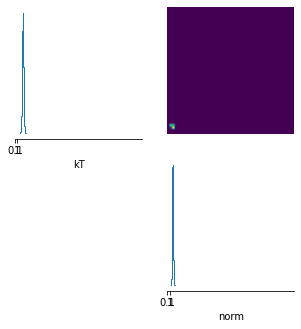

In [5]:
samples = posterior.sample((100000,), x=x0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 50], [0.1, 50]],
    ticks=[[0.1, 50], [0.1, 1,2,3,4,5,6,7,8,9,10]],
    figsize=(5, 5),
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=['kT', 'norm']
)

In [12]:
np.mean(np.array(samples), axis=0)

array([3.1243284, 2.1991422], dtype=float32)